# MAPS calculation 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

sns.set_context("talk")

In [2]:
syn = pd.read_csv(
    "../outputs/proportion_singletons_synonymous_by_context.tsv", sep="\t"
)
syn_no_cpg = syn[syn.variant_type != "CpG"]

In [3]:
model = smf.wls("ps ~ mu", data=syn_no_cpg, weights=syn_no_cpg["n_obs"]).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.794
Model:                            WLS   Adj. R-squared:                  0.793
No. Observations:                 176   F-statistic:                     669.7
Covariance Type:            nonrobust   Prob (F-statistic):           1.51e-61
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5557      0.003    221.100      0.000       0.551       0.561
mu         -9.873e+06   3.81e+05    -25.879      0.000   -1.06e+07   -9.12e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.12e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

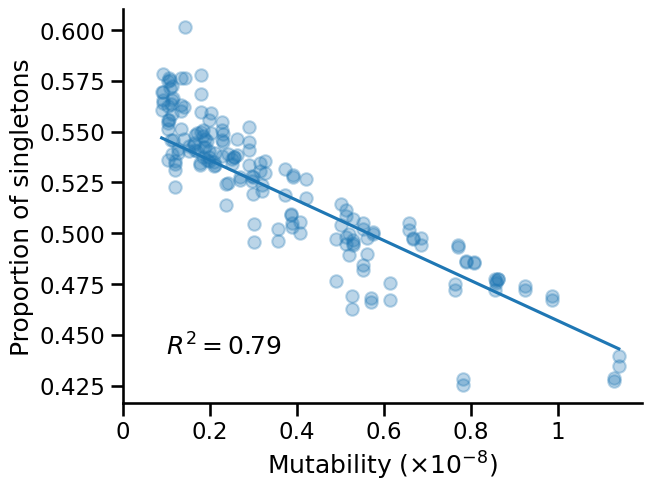

In [4]:
fig, ax = plt.subplots(layout="constrained")

ax.scatter(x=syn_no_cpg["mu"], y=syn_no_cpg["ps"], alpha=0.3)
ax.set_xlabel(r"Mutability ($\times10^{-8}$)")
ax.set_ylabel("Proportion of singletons")

ax.spines["top"].set_color("None")
ax.spines["right"].set_color("None")

x1 = min(syn_no_cpg["mu"])
x2 = max(syn_no_cpg["mu"])
y1, y2 = [x * model.params.mu + model.params.Intercept for x in [x1, x2]]
ax.text(x=0.1*10**-8, y=0.44, s=fr"$R^2 = {np.round(model.rsquared,2)}$")

ax.plot([x1,x2],[y1,y2])

xlabels = [0, 0.2, 0.4, 0.6, 0.8, 1]
ax.set_xticks([x * 10**-8 for x in xlabels], labels=xlabels)

plt.savefig("../plots/proportion_singletons_synonymous_vs_mu.svg", format="svg")

In [5]:
df = pd.read_csv(
    "../outputs/proportion_singletons_by_csq_and_region_no_cpg.tsv", sep="\t"
)

df["csq"] = pd.Categorical(
    df["csq"],
    categories=[
        "synonymous",
        "missense",
        "nonsense",
        "nmd_target",
        "long_exon",
        "distal_nmd",
        "start_proximal",
    ],
)

df = df.sort_values("csq")

df["se"] = np.sqrt((df["ps"] * (1 - df["ps"])) / df["n_obs"])
df["ps_pred"] = model.predict(df["mu"])
df["maps"] = np.round((df["ps"] - df["ps_pred"]), 3)
df["ci95"] = 1.96 * df["se"]

df.to_csv("../outputs/proportion_singletons_maps_summary_statistics.tsv", sep="\t", index=False)

df

,csq,mu,n_singletons,n_obs,ps,se,ps_pred,maps,ci95
2,synonymous,5.987558e-09,1395327,2810047,0.496549,0.000298,0.496549,0.000,0.000585
0,missense,5.019917e-09,3297481,6201057,0.531761,0.000200,0.506103,0.026,0.000393
1,nonsense,4.957895e-09,117416,192416,0.610220,0.001112,0.506715,0.104,0.002179
5,nmd_target,5.003376e-09,69208,111290,0.621871,0.001454,0.506266,0.116,0.002849
4,long_exon,4.798374e-09,7895,12338,0.639893,0.004322,0.508290,0.132,0.008470
3,distal_nmd,4.823988e-09,29094,49500,0.587758,0.002212,0.508037,0.080,0.004336
6,start_proximal,5.141169e-09,11219,19288,0.581657,0.003552,0.504906,0.077,0.006962
